# Spatial Joining Parks and Arrests

I am now working on joining the entire arrest data from 2021 to the NYC parks GeoJson. I will explore using a .5 mile buffer to see how arrests in and around parks compare to the overall arrests distribution. This will help inform our predictive model of how proximity to/being within a park might skew the types of arrests happening. 

In [1]:
import pandas as pd
import geopandas as gpd
import requests
import json

In [2]:
requestString = 'https://data.cityofnewyork.us/resource/4j29-i5ry.geojson'
parkgdf = gpd.read_file(requestString)
parkgdf


propname retireddate zipcode              acres  \
0                Devoe Park        None   10468         0.82058454   
1               Brower Park        None   11213         0.80198644   
2    Sara D. Roosevelt Park        None   10002         0.78430157   
3        River Avenue Parks        None   10451              0.439   
4               Cooper Park        None   11211         0.52813527   
..                      ...         ...     ...                ...   
903       St. Nicholas Park        None   10031         7.70325311   
904       St. Nicholas Park        None   10027         8.34828471   
905         Highbridge Park        None   10032  8.783184350000001   
906        Fort Greene Park        None   11201         5.59669217   
907        Fort Totten Park        None   11359  9.106230719999999   

                                              location nys_assembly  \
0         University Ave & Fr Zeiser Pl, Near W 188 St           78   
1                           Brooklyn Ave & Prospect Pl           43   
2                               Bet Grand & Hester Sts           65   
3                 South Side Of E 157th St & River Ave           84   
4                       Sharon & Olive Sts, Morgan Ave           53   
..                                                 ...          ...   
903      135 To 141 Sts/St. Nicholas Ave To Upper Path           70   
904      128 To 135 Sts/St. Nicholas Ave To Upper Path           70   
905  Edgecombe Av, approx W 163 to W 173 Sts (to pa...           72   
906             Central Hill Including Monument And CS           57   
907        Murray Ave, Story Ave, Shore Rd, Weaver Ave           26   

    councildistrict                                 description us_congress  \
0                14                       Devoe Park-Devoe Park          13   
1                36                     Brower Park-Brower Park           9   
2                 1  Sara D Roosevelt Park-Hester St Playground           7   
3                 8                     River Avenue Skate Park          15   
4                34             Cooper Park-Carnegie Playground          12   
..              ...                                         ...         ...   
903               9                    St Nicholas Park Zone 02          13   
904               9                    St Nicholas Park Zone 01          13   
905              10                      Highbridge Park Zone 8          13   
906              35                     Fort Greene Park Zone 3           8   
907              19                     Fort Totten Park Zone 2           3   

    gispropnum  retired communityboard department        subcategory precinct  \
0         X013    False            207       X-05   Plgd Within Park       52   
1         B012    False            308       B-08   Plgd Within Park       77   
2         M105    False            103       M-03   Plgd Within Park        5   
3         X348    False            204       X-04  Neighborhood Plgd       44   
4         B025    False            301       B-01   Plgd Within Park       90   
..         ...      ...            ...        ...                ...      ...   
903       M077    False            109       M-09    Large Park Zone       26   
904       M077    False            109       M-09    Large Park Zone       26   
905       M037    False            112      M-12A    Large Park Zone       33   
906       B032    False            302       B-02    Large Park Zone       88   
907       Q458    False            407      Q-07A    Large Park Zone      109   

     omppropid                  sitename nys_senate borough  \
0      X013-01                Devoe Park         33       X   
1      B012-03               Brower Park         25       B   
2      M105-08            Hester St Plgd         26       M   
3      X348-02        River Avenue Parks         29       X   
4      B025-01             Carnegie Plgd         18       B   
..         ...           

In [ ]:
arrests = pd.read_pickle('../NYCParks-SAEC/results_df.pandas')

arrests = gpd.GeoDataFrame(arrests, 
                        geometry = gpd.points_from_xy(
                         arrests.longitude, 
                         arrests.latitude, crs='EPSG:4326'))

# check it looks OK
arrests


In [ ]:
# want to check out the timeframe for my arrests
print(arrests['arrest_date'].min())
print(arrests['arrest_date'].max())

#ok cool it's for all of 2021! 

## Buffering Parks

I wanted to buffer the parks to look at how arrest types within and around parks might compare to the overall summary of arrests from the entire city. I figured out how to do the buffer from [here](https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=8c7845401171b96755e3facf9b241730f373483a&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f67656f70616e6461732f67656f70616e6461732f386337383435343031313731623936373535653366616366396232343137333066333733343833612f646f632f736f757263652f67657474696e675f737461727465642f696e74726f64756374696f6e2e6970796e62&logged_in=false&nwo=geopandas%2Fgeopandas&path=doc%2Fsource%2Fgetting_started%2Fintroduction.ipynb&platform=android&repository_id=11002815&repository_type=Repository&version=98) and [here](https://stackoverflow.com/questions/51263138/how-to-create-an-accurate-buffer-of-5-miles-around-a-coordinate-in-python), as well as reading the [geopandas buffer documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html). 

In [3]:
#convert parks GDF to a projection that will preserve area, then buffer it 1 mile 
parkgdf= parkgdf.to_crs({'init': 'epsg:32118'})  
buffer_length_in_meters = 80
#average block size within NYC is 264 feet, so we wanted to see the types of arrests happening in parks and within 1 block of them 
parkgdf['geometry'] = parkgdf.geometry.buffer(buffer_length_in_meters)
parkgdf

# buffering the active geometry by 10 000 feet (geometry is already in feet)

/Applications/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


propname retireddate zipcode              acres  \
0                Devoe Park        None   10468         0.82058454   
1               Brower Park        None   11213         0.80198644   
2    Sara D. Roosevelt Park        None   10002         0.78430157   
3        River Avenue Parks        None   10451              0.439   
4               Cooper Park        None   11211         0.52813527   
..                      ...         ...     ...                ...   
903       St. Nicholas Park        None   10031         7.70325311   
904       St. Nicholas Park        None   10027         8.34828471   
905         Highbridge Park        None   10032  8.783184350000001   
906        Fort Greene Park        None   11201         5.59669217   
907        Fort Totten Park        None   11359  9.106230719999999   

                                              location nys_assembly  \
0         University Ave & Fr Zeiser Pl, Near W 188 St           78   
1                           Brooklyn Ave & Prospect Pl           43   
2                               Bet Grand & Hester Sts           65   
3                 South Side Of E 157th St & River Ave           84   
4                       Sharon & Olive Sts, Morgan Ave           53   
..                                                 ...          ...   
903      135 To 141 Sts/St. Nicholas Ave To Upper Path           70   
904      128 To 135 Sts/St. Nicholas Ave To Upper Path           70   
905  Edgecombe Av, approx W 163 to W 173 Sts (to pa...           72   
906             Central Hill Including Monument And CS           57   
907        Murray Ave, Story Ave, Shore Rd, Weaver Ave           26   

    councildistrict                                 description us_congress  \
0                14                       Devoe Park-Devoe Park          13   
1                36                     Brower Park-Brower Park           9   
2                 1  Sara D Roosevelt Park-Hester St Playground           7   
3                 8                     River Avenue Skate Park          15   
4                34             Cooper Park-Carnegie Playground          12   
..              ...                                         ...         ...   
903               9                    St Nicholas Park Zone 02          13   
904               9                    St Nicholas Park Zone 01          13   
905              10                      Highbridge Park Zone 8          13   
906              35                     Fort Greene Park Zone 3           8   
907              19                     Fort Totten Park Zone 2           3   

    gispropnum  retired communityboard department        subcategory precinct  \
0         X013    False            207       X-05   Plgd Within Park       52   
1         B012    False            308       B-08   Plgd Within Park       77   
2         M105    False            103       M-03   Plgd Within Park        5   
3         X348    False            204       X-04  Neighborhood Plgd       44   
4         B025    False            301       B-01   Plgd Within Park       90   
..         ...      ...            ...        ...                ...      ...   
903       M077    False            109       M-09    Large Park Zone       26   
904       M077    False            109       M-09    Large Park Zone       26   
905       M037    False            112      M-12A    Large Park Zone       33   
906       B032    False            302       B-02    Large Park Zone       88   
907       Q458    False            407      Q-07A    Large Park Zone      109   

     omppropid                  sitename nys_senate borough  \
0      X013-01                Devoe Park         33       X   
1      B012-03               Brower Park         25       B   
2      M105-08            Hester St Plgd         26       M   
3      X348-02        River Avenue Parks         29       X   
4      B025-01             Carnegie Plgd         18       B   
..         ...           

Text(0.5, 1.0, 'NYC Parks 0.5 Mile Buffer')

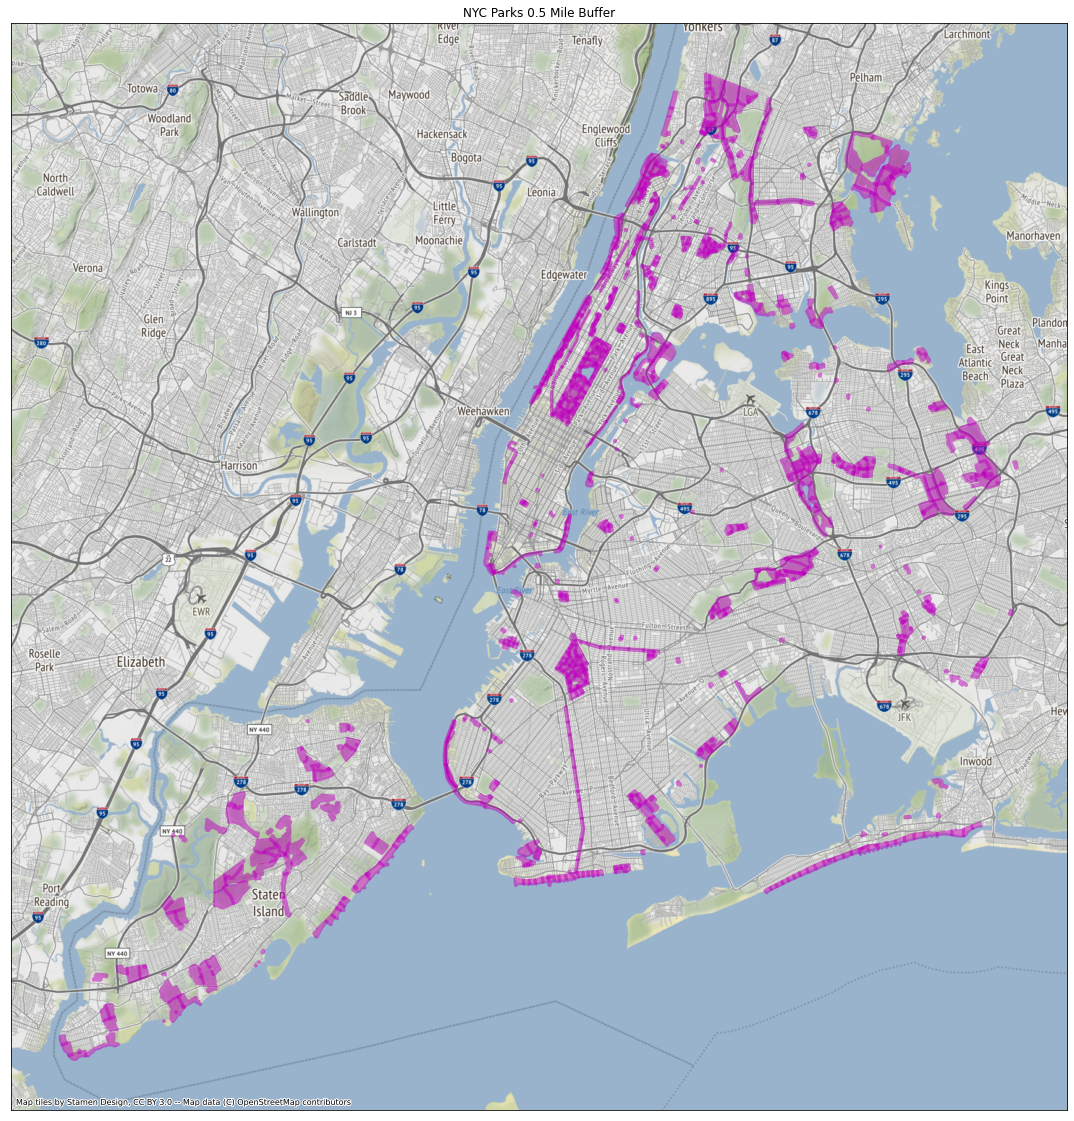

In [4]:
import contextily as ctx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))
# Plot the data. ax=ax means we plot it on the axes that we just created
parkgdf.to_crs('EPSG:3857').plot(color='m', alpha=0.5, ax=ax) 

# Let's add a basemap using the contextily library
# Note that we add it to the same axes object. 
# The zoom level is trial and error
ctx.add_basemap(ax, zoom=12)

# and we really don't need the axis ticks and labels, so we set them to an empty list
ax.set_xticks([])
ax.set_yticks([])
plt.title("NYC Parks 0.5 Mile Buffer")

In [9]:
parkgdf.info()
parks_union.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   propname         908 non-null    object  
 1   retireddate      0 non-null      object  
 2   zipcode          908 non-null    object  
 3   acres            902 non-null    object  
 4   location         908 non-null    object  
 5   nys_assembly     906 non-null    object  
 6   councildistrict  908 non-null    object  
 7   description      908 non-null    object  
 8   us_congress      906 non-null    object  
 9   gispropnum       904 non-null    object  
 10  retired          908 non-null    bool    
 11  communityboard   907 non-null    object  
 12  department       908 non-null    object  
 13  subcategory      906 non-null    object  
 14  precinct         908 non-null    object  
 15  omppropid        908 non-null    object  
 16  sitename         908 non-null    obj

In [12]:
#one to many join 
parkgdf['new_column'] = 0
parkgdf_new = parkgdf.dissolve(by='new_column')
parkgdf_new

geometry    propname  \
new_column                                                                  
0           MULTIPOLYGON (((278706.857 36733.216, 278705.1...  Devoe Park   

           retireddate zipcode       acres  \
new_column                                   
0                 None   10468  0.82058454   

                                                location nys_assembly  \
new_column                                                              
0           University Ave & Fr Zeiser Pl, Near W 188 St           78   

           councildistrict            description us_congress gispropnum  \
new_column                                                                 
0                       14  Devoe Park-Devoe Park          13       X013   

            retired communityboard department       subcategory precinct  \
new_column                                                                 
0             False            207       X-05  Plgd Within Park       52   

           omppropid    sitename nys_senate borough  
new_column                                           
0            X013-01  Devoe Park         33       X

Text(0.5, 1.0, 'NYC Parks 1 Block Buffer')

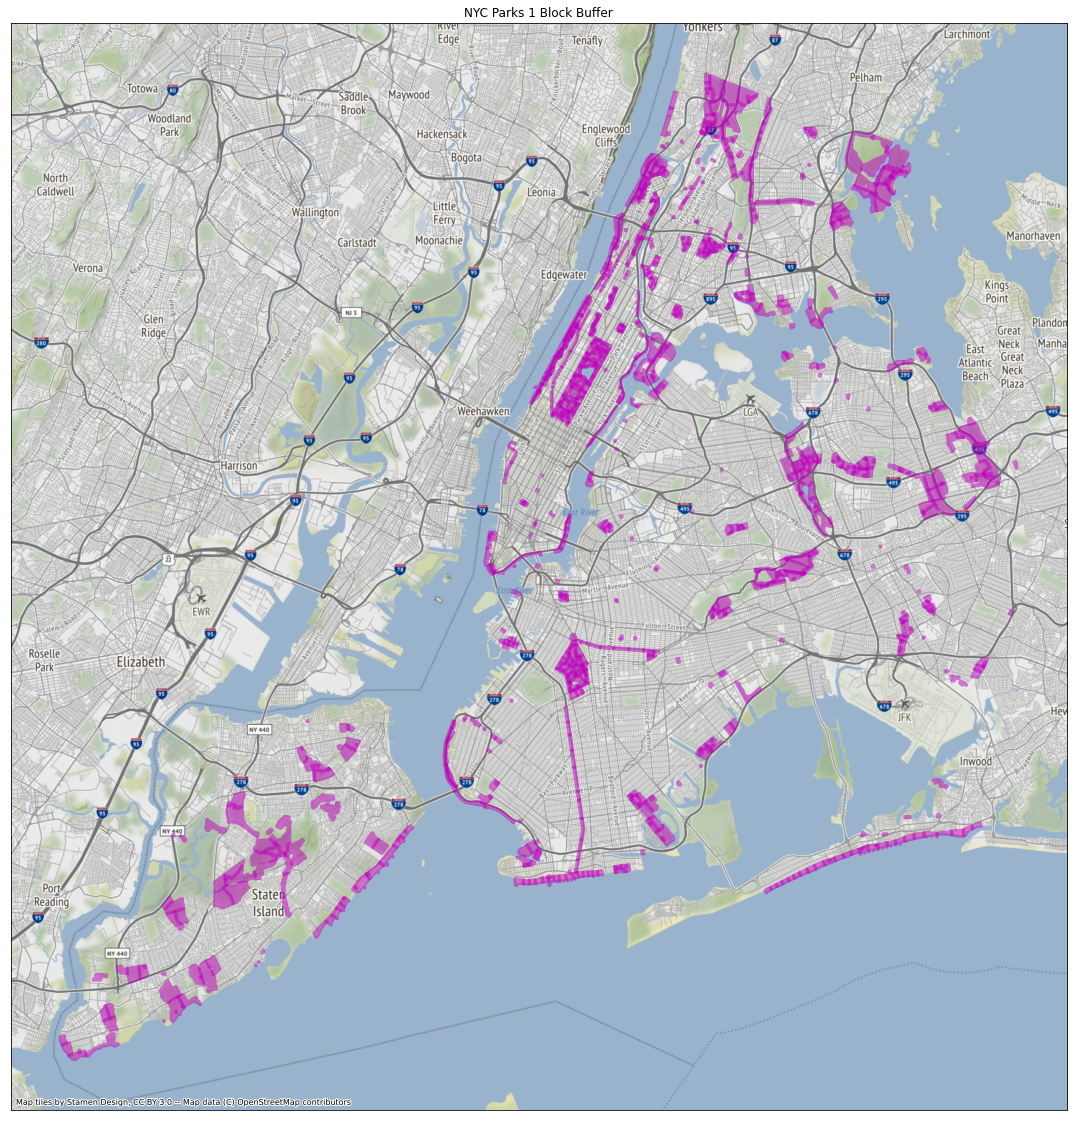

In [17]:
fig, ax = plt.subplots(figsize=(20,20))
# Plot the data. ax=ax means we plot it on the axes that we just created
parkgdf.to_crs('EPSG:3857').plot(color='m', alpha=0.5, ax=ax) 

# Let's add a basemap using the contextily library
# Note that we add it to the same axes object. 
# The zoom level is trial and error
ctx.add_basemap(ax, zoom=12)

# and we really don't need the axis ticks and labels, so we set them to an empty list
ax.set_xticks([])
ax.set_yticks([])
plt.title("NYC Parks 1 Block Buffer")

Trying [this method](https://gis.stackexchange.com/questions/271733/geopandas-dissolve-overlapping-polygons) to dissolve my parks polygons (see the last post)

In [23]:
parks_smooth = gpd.GeoDataFrame(
  geometry=[parkgdf.unary_union]).explode(
  index_parts=False).reset_index(
  drop=True)

parks_smooth
parks_smooth = gpd.GeoDataFrame(parks_smooth, geometry='geometry')


ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

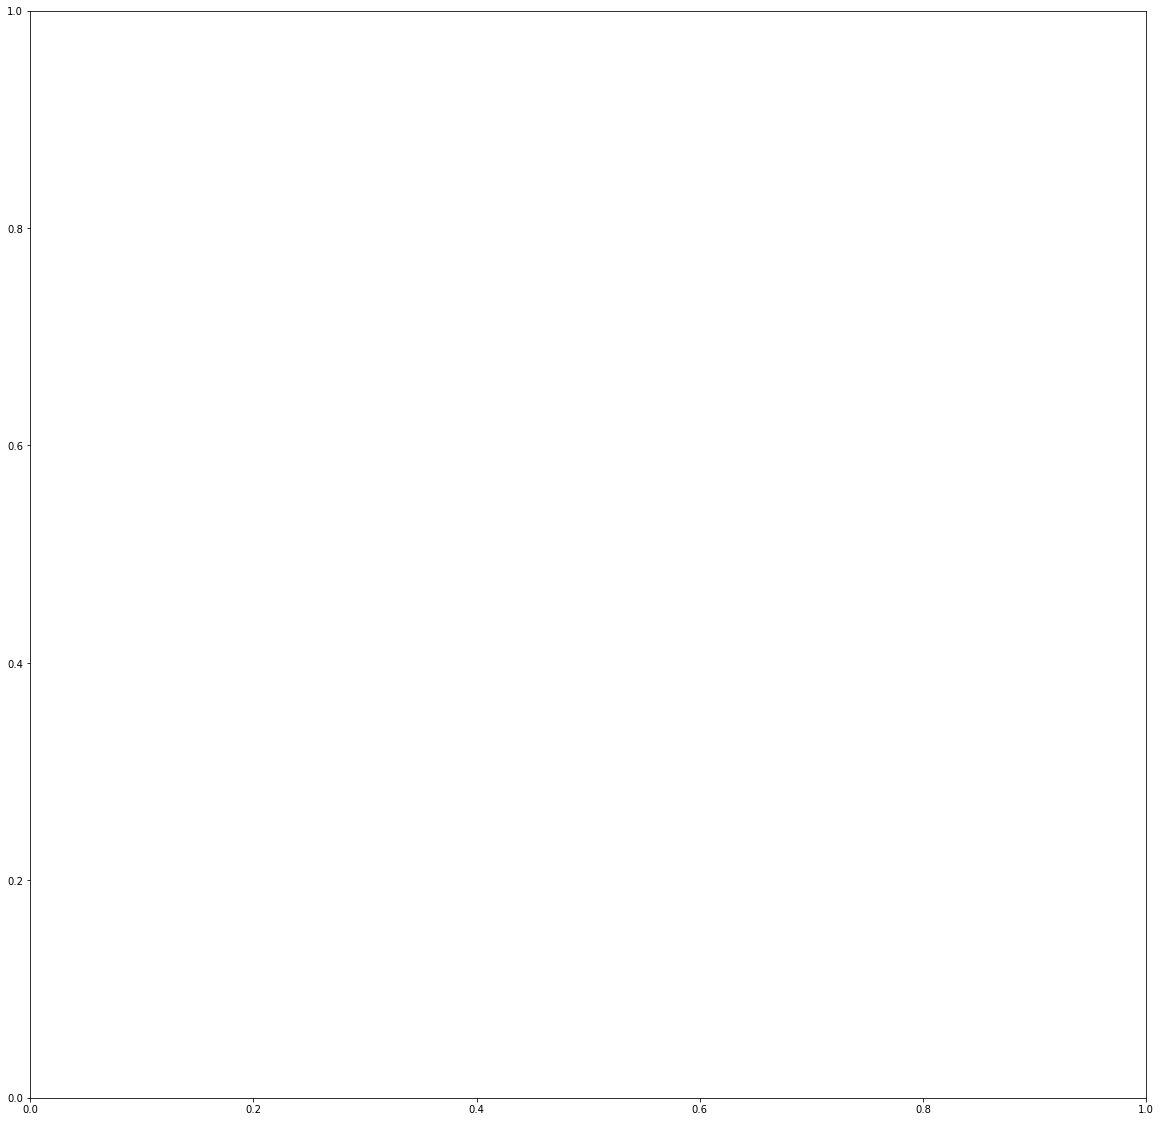

In [24]:
fig, ax = plt.subplots(figsize=(20,20))
# Plot the data. ax=ax means we plot it on the axes that we just created
parks_smooth.to_crs('EPSG:3857').plot(color='m', alpha=0.5, ax=ax) 

# Let's add a basemap using the contextily library
# Note that we add it to the same axes object. 
# The zoom level is trial and error
ctx.add_basemap(ax, zoom=12)

# and we really don't need the axis ticks and labels, so we set them to an empty list
ax.set_xticks([])
ax.set_yticks([])
plt.title("NYC Parks 1 Block Buffer")

In [25]:
parkgdf = parkgdf.to_crs('EPSG:4326')
# next step will be to use the "sjoin_nearest" we learned in lecture to look at the arrests happening near parks. Stay turned!

In [ ]:
parksarrests = gpd.sjoin(parkgdf, arrests, predicate='intersects', how='right')